In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from dotenv import load_dotenv
from pandas.plotting import parallel_coordinates

import os
import glob
import pandas as pd
import json

from utils.db_tools import get_db, filter_df, make_animation, get_data, metrics_grid, plot_grid

In [2]:
def classify_trajectories(
    df,
    steady_threshold=1e-3,
    osc_threshold=1e-2,
    dev_threshold=1e-2,
) -> pd.DataFrame:
    """
    Classify runs based on behavior: inserts column 'category' into DataFrame.
    Possible categories: 'steady_state', 'interesting', 'divergent_or_unknown'.
    Args:
        df: DataFrame containing run metadata.
        steady_threshold: Threshold for ||du/dt|| to classify as steady.
        osc_threshold: Threshold for oscillatory behavior.
        dev_threshold: Threshold for deviation from the steady state.

    Returns:
        Updated DataFrame with classification labels.
    """

    if len(df) == 0:
        return None

    classifications = []
    for i, row in df.iterrows():
        final_dev = row["final_deviation"]
        mean_dev = row["mean_deviation"]
        std_dev = row["std_deviation"]
        max_derivative = row["max_derivative"]

        if final_dev < dev_threshold or (
            final_dev < 5 * dev_threshold and max_derivative < steady_threshold
        ):
            category = "steady_state"
        elif std_dev > osc_threshold or mean_dev > dev_threshold:
            category = "interesting_behavior"
        else:
            category = "divergent_or_unknown"
        classifications.append(category)

    df["category"] = classifications
    return df


In [3]:
model = "bruss"
run_id = "abd_big"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
df = pd.read_csv(f"{output_dir}/{model}/{run_id}/classif_metrics.csv", index_col=0)
df = classify_trajectories(df, steady_threshold=1, osc_threshold=1, dev_threshold=1)
df.value_counts("category")

category
interesting_behavior    2496
steady_state            1104
Name: count, dtype: int64

In [4]:
grouped = df.groupby(['A', 'B', 'Du', 'Dv'])['category']

def classify_category(group):
    unique_categories = group.unique()
    if len(unique_categories) == 1:
        return unique_categories[0]
    else:
        return 'varying'

# Apply classification
category_mapping = grouped.apply(classify_category).reset_index(name='category')

# Drop random_seed and keep only unique parameter combinations
df_new = df.drop(columns=['random_seed', 'category']).drop_duplicates(subset=['A', 'B', 'Du', 'Dv'])

# Merge the new category values
df_new = df_new.merge(category_mapping, on=['A', 'B', 'Du', 'Dv'])

percentages = df_new.value_counts("category") / len(df_new)

In [5]:
df_varying = df_new[df_new.category == 'varying']
n_varying = len(df_varying)

n_steady = n_varying
n_interesting = int(n_steady * percentages["interesting_behavior"] / percentages["steady_state"])

In [6]:
df_steady = df_new[df_new.category == "steady_state"].sample(n=n_steady)
df_interesting = df_new[df_new.category == "interesting_behavior"].sample(n=n_interesting)

sampling_centers = pd.concat([df_steady, df_interesting, df_varying])

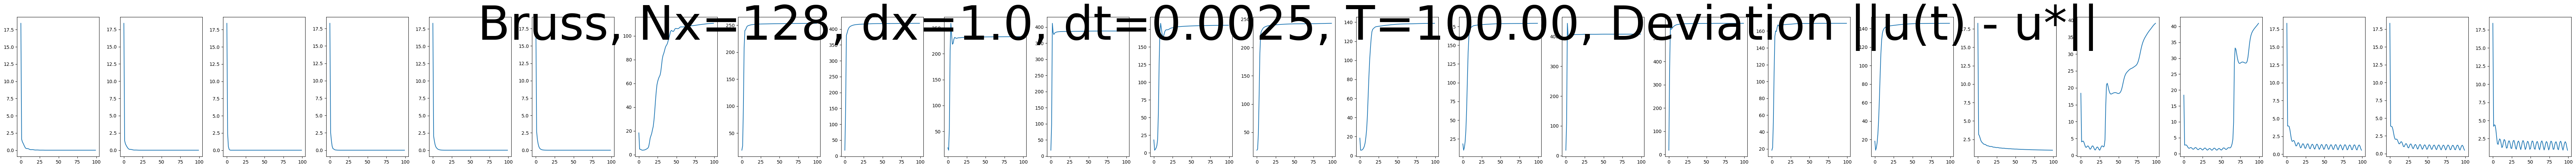

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

In [7]:
metrics_grid(sampling_centers, 0, var1="", var2="")

In [8]:
sampling_centers.to_csv("../data/sampling_centers.csv")